In [1]:
import pyDOE as pd
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import GPy
import pickle
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [2]:
# Plotting size
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

In [3]:
def scale(col, min, max):
    range = col.max() - col.min()
    a = (col - col.min()) / range
    return a * (max - min) + min

def scalex(col, min, max, xmax, xmin):
    range = xmax - xmin
    a = (col - xmin) / range
    return a * (max - min) + min

def rescale(xntd,min,max,x):
    xall = np.vstack((xntd,x))
    xalls = np.zeros((xall.shape[0],xall.shape[1]))
    
    # Scale values between min and max
    for i in range(xalls.shape[1]):
        xalls[:,i] = scalex(xall[:,i],min,max,x[:,i].max(),x[:,i].min())
        #xalls[:,i] = scale(xall[:,i],min,max)

    xntds = np.zeros((xntd.shape[0],xntd.shape[1]))

    for i in range(xntds.shape[1]):
        xntds[:,i] = xalls[0:(xntd.shape[0]),i]
        
    return xntds
    
def checkBound(xntd,x):
    for i in range(0,x.shape[1]):
        if xntd[:,i].max() > x[:,i].max():
            print("Max value for parameter in index %d out of training bounds."%(i))
        if xntd[:,i].min() < x[:,i].min():
            print("Min value for parameter in index %d out of training bounds."%(i))
            

## Load data

In [4]:
# # ===================================================== #
# #                       Load data                       #
# # ===================================================== #
l0 = 0.2
v0 = l0**3.
loc = "/home/jbarsima/Desktop/adip_size/"
#loc = "/scratch/bell/jbarsima/adip_size/"

# Load deformed configuration
X = np.loadtxt(loc+'RVE_Psi_1p15.csv', delimiter=',', unpack=True) # Material parameters probed
X = X.transpose()

# Load deformed + eps configuration
Xplus = np.loadtxt(loc+'RVE_Psi_plus_1p15.csv', delimiter=',', unpack=True) # Material parameters probed
Xplus = Xplus.transpose()


# Load deformed - eps configuration
Xminus = np.loadtxt(loc+'RVE_Psi_minus_1p15.csv', delimiter=',', unpack=True) # Material parameters probed
Xminus = Xminus.transpose()


param_n = 4

#X: D, Dstd, 1-S, Sstd, Psi, Psi Vol, Psi Area, Psi edge, Volume, Cells

x = X[:,0:param_n] #D, Dstd, S, Sstd

x[:,2] = 1 - x[:,2] #Converting the value to sphericity (original value is 1 - sphericity)
psi = X[:,4] #Psi total
psi = psi.reshape(-1,1)
Vf = X[:,-2].reshape(-1,1) #Actual final volume
ncell = X[:,-1].reshape(-1,1)

xplus = Xplus[:,0:4] #D, Dstd, S, Sstd
xplus[:,2] = 1 - xplus[:,2] 
psi_plus = Xplus[:,4] #Psi plus total
psi_plus = psi_plus.reshape(-1,1)
ncell = Xplus[:,-1].reshape(-1,1)

xminus = Xminus[:,0:4] #D, Dstd, S, Sstd
xminus[:,2] = 1 - xminus[:,2] 
psi_minus = Xminus[:,4] #Psi minus total
psi_minus = psi_minus.reshape(-1,1)
Vf = Xminus[:,-2].reshape(-1,1) #Actual final volume
ncell = Xminus[:,-1].reshape(-1,1)

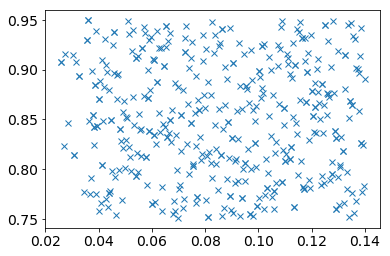

In [5]:
plt.plot(x[:,0],x[:,2],'x')

## Stress

In [6]:
eps = 10.**-6
Vi = 0.5**3
#J = Vf/Vi
#lam = J**(1./3.)
lam = 1.15
J = lam**3
len_minus = len(psi_minus)
dpsidlam = (psi_plus[:len_minus] - psi_minus)/(2*eps) #Central difference
y = (J**-1)*lam*dpsidlam #Stress
len(psi_minus)

434

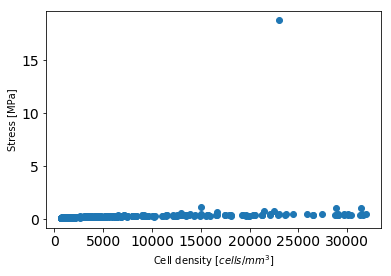

3987.0
D: 0.025741920251179825 0.13994479290763556
Dstd: 0.001055707841638852 0.019973277181143518
S: 0.7508203346601857 0.9495145156070691
Sstd: 0.0010731567204250554 0.03998533270707109


In [7]:
plt.plot((ncell/0.5**3)**1,y,'o')
plt.xlabel('Cell density [$cells/{mm^{3}}$]')
plt.ylabel('Stress [MPa]')
plt.show()

print((ncell).max())
print('D:',x[:,0].min(),x[:,0].max())
print('Dstd:',x[:,1].min(),x[:,1].max())
print('S:',x[:,2].min(),x[:,2].max())
print('Sstd:',x[:,3].min(),x[:,3].max())

## Clean data

In [8]:
xy = np.hstack((x,y))
# get a boolean mask of rows where the last column value is greater than 1
mask = xy[:, -1] > 0.9
# use boolean indexing to remove rows where the last column value is greater than 1
x = cp.deepcopy(xy[~mask])

yclean = x[:,-1]
xclean = x[:,:-1]

## Train GP

In [9]:
# Scale X values between a and b
a = 0.
b = 1.
xs = np.zeros((xclean.shape[0],xclean.shape[1]))

for i in range(xs.shape[1]):
    xs[:,i] = scale(xclean[:,i],a,b)

Xtrain, Xtest, ytrain, ytest = train_test_split(xclean, yclean, train_size=0.60, random_state=21)

 /apps/spack/brown/apps/anaconda/5.1.0-py36-gcc-4.8.5-5cfpkzk/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning:From version 0.21, test_size will always complement train_size unless both are specified.


## GP

In [10]:
# RBF
ls = 1
kernel = GPy.kern.RBF(input_dim=xs.shape[1], ARD=True, lengthscale=[ls,ls,ls,ls]) #When using scaled values
#print(k)

# Set up model
m = GPy.models.GPRegression(Xtrain,ytrain.reshape(-1,1),kernel,mean_function=None)
#print(m_count)

# Plot the unfit version
#fig = m.plot()

m.optimize(messages=True,max_f_eval=1000)
#m.optimize_restarts(num_restarts = 10)
print(m)

HBox(children=(VBox(children=(IntProgress(value=0, max=1000), HTML(value=''))), Box(children=(HTML(value=''),))))


Name : GP regression
Objective : -501.0677599947639
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     0.2863903771542566  |      +ve      |        
  rbf.lengthscale          |                   (4,)  |      +ve      |        
  Gaussian_noise.variance  |  0.0007937081354600359  |      +ve      |        


In [11]:
m.kern.lengthscale
#C = kernel.K(Xtest,Xtest)
#plt.matshow(C)

index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.05081821,+ve,
[1],0.85965278,+ve,
[2],0.38882846,+ve,
[3],0.04998620,+ve,


0.6785836177383289


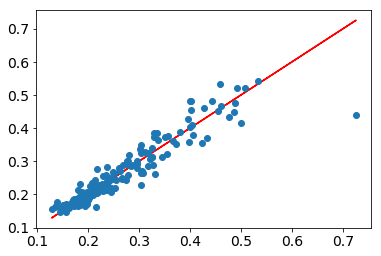

In [12]:
ypred,var = m.predict(Xtest)

j = 0

yp = ypred + 1.96*np.sqrt(var)
ym = ypred - 1.96*np.sqrt(var)

print(np.sqrt(np.sum(ypred-ytest)**2/len(ypred)))
plt.plot(ytest,ytest,'-r')
plt.plot(ytest,ypred,'o')
#plt.xlim([0.1, 0.6])
#plt.ylim([0.1, 0.6])
#plt.plot(ypred,ypred,'-g')

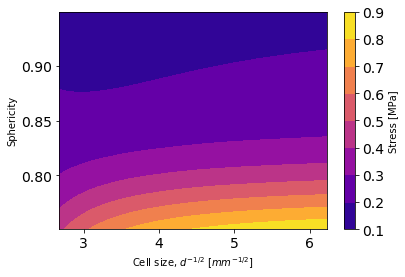

In [13]:
# Define the input array Xtest
p = 32
Xcont = cp.deepcopy(Xtest[p,:])
n = 0
k = 2

Ns = 25

# Create a contour plot based on the model predictions for Xtest
dx = np.linspace(a, b, Ns)
dy = np.linspace(a, b, Ns)
Xplot = np.linspace(xclean[:,n].min(),xclean[:,n].max(),Ns)
Yplot = np.linspace(xclean[:,k].min(),xclean[:,k].max(),Ns)
X, Y = np.meshgrid(dx, dy)
DX, DY = np.meshgrid(Xplot, Yplot)
Z = np.zeros((len(dx), len(dy)))

for i in range(len(dx)):
    for j in range(len(dy)):
        Xcont[n] = Xplot[i]
        Xcont[k] = Yplot[j]
        #Xcont[n] = dx[i]
        #Xcont[k] = dy[j]
        ycontour, oo = m.predict(Xcont.reshape(1,4))
        Z[i, j] = ycontour

plt.contourf(DX**-0.5, DY, Z, cmap='plasma')
cb = plt.colorbar(label='Stress [MPa]')
cb.ax.yaxis.set_minor_formatter(ticker.NullFormatter())
plt.xlabel('Cell size, $d^{-1/2}$ [$mm^{-1/2}$]')
plt.ylabel('Sphericity')
plt.show()

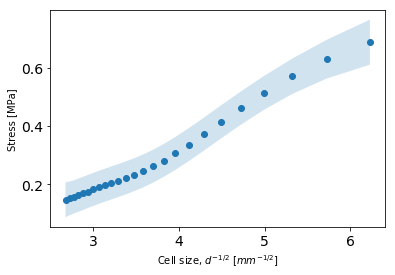

In [14]:
Dplot = np.linspace(xclean[:,0].min(),xclean[:,0].max(),Ns)
XD_Plot = np.zeros((len(Dplot),4))
Dstd_ = Xtest[p,1]
S_ = Xtest[p,2]
Sstd_ = Xtest[p,3]
for i in range(len(XD_Plot)):
    XD_Plot[i,0] = Dplot[i]
    XD_Plot[i,1] = Dstd_
    XD_Plot[i,2] = S_
    XD_Plot[i,3] = Sstd_
    
S_pred,var = m.predict(XD_Plot)
splus = S_pred+1.96*np.sqrt(var)
sminus = S_pred-1.96*np.sqrt(var)
plt.plot(XD_Plot[:,0]**-0.5,S_pred,'o')
plt.fill_between(XD_Plot[:,0]**-0.5,splus[:,0],sminus[:,0],alpha=0.2,label='95% confidence interval')
plt.xlabel('Cell size, $d^{-1/2}$ [$mm^{-1/2}]$')
plt.ylabel('Stress [MPa]')
#plt.legend()
plt.show()

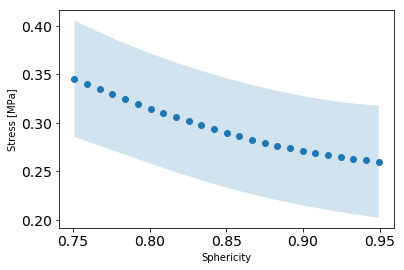

In [15]:
Splot = np.linspace(xclean[:,2].min(),xclean[:,2].max(),Ns)
XS_Plot = np.zeros((len(Splot),4))
D_ = Xtest[p,0]
Dstd_ = Xtest[p,1]
Sstd_ = Xtest[p,3]
for i in range(len(XS_Plot)):
    XS_Plot[i,0] = D_
    XS_Plot[i,1] = Dstd_
    XS_Plot[i,2] = Splot[i]
    XS_Plot[i,3] = Sstd_
    
S_pred,var = m.predict(XS_Plot)
splus = S_pred+1.96*np.sqrt(var)
sminus = S_pred-1.96*np.sqrt(var)
plt.plot(XS_Plot[:,2],S_pred,'o')
plt.fill_between(XS_Plot[:,2],splus[:,0],sminus[:,0],alpha=0.2,label='95% confidence interval')
plt.xlabel('Sphericity')
plt.ylabel('Stress [MPa]')
#plt.legend()
plt.show()